In [1]:
# math 
import numpy as np

# random
import random

# matrix inverse
from numpy.linalg import inv

# dataframes
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn

# linear regression two ways
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# for choosing covariates to include in model
from patsy import dmatrices

In [2]:
# plot line y = w*x+b
def plotline(w,b, xmin=-100,xmax=100,nsamples=100,label=''):
    x = np.linspace(xmin, xmax, nsamples)
    y = w * x + b
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

In [4]:
# plot function y = f(x)
def plotfunc(f, xmin=-100,xmax=100,nsamples=100,label=""):
    x = np.linspace(xmin, xmax, nsamples)
    y = f(x)
    plt.plot(x, y, color='k', label=label)
    plt.legend(loc="upper left")
    plt.grid()

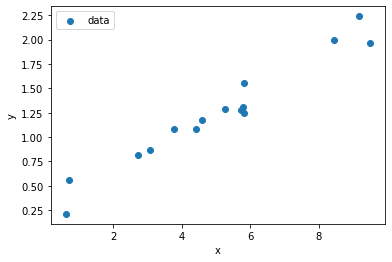

In [6]:
# Generate and plot data
random.seed(1)
n = 15
def sample_data(num_points):
    x = np.random.rand(num_points)*10
    y = .2 + .2*x + .1*np.sin(x) + .1*np.random.randn(num_points) - .01*((x-5)/6)**4
    return x,y

x,y = sample_data(n)


def plotdata(x=x,y=y, margin=.05):
    plt.scatter(x,y, label="data")
    plt.legend(loc="upper left")
    plt.xlabel("x") 
    plt.ylabel("y")     
    range_y = np.max(y) - np.min(y)
    range_x = np.max(x) - np.min(x)
    plt.ylim([np.min(y)-margin*range_y,np.max(y)+margin*range_y])
    plt.xlim([np.min(x)-margin*range_x,np.max(x)+margin*range_x])
    
plotdata()
plt.show()

# Approximating with the mean

In [7]:
# the mean solves a very simple least squares problem:
X = np.ones([n,1])
w = np.linalg.lstsq(X, y)[0]

<ipython-input-7-85d6efe6f3d9>:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [8]:
# check the solution to our least squares problem is the mean
np.abs(np.mean(y) - w[0])

2.220446049250313e-16

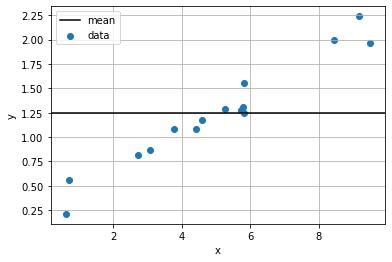

In [9]:
# plot the fit
plotdata()
plotline(0, w[0], label="mean")
plt.show()

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

# Approximating with a line

In [10]:
X = np.column_stack([x, np.ones(n)])
print(X)

[[0.61136274 1.        ]
 [2.72907808 1.        ]
 [0.71314919 1.        ]
 [5.82820938 1.        ]
 [3.78340496 1.        ]
 [4.41147667 1.        ]
 [5.26650799 1.        ]
 [5.74505031 1.        ]
 [9.18312641 1.        ]
 [8.45716362 1.        ]
 [3.05871425 1.        ]
 [5.79636968 1.        ]
 [4.59010194 1.        ]
 [5.82158086 1.        ]
 [9.50863742 1.        ]]


In [11]:
w = np.linalg.lstsq(X, y)[0]
print(w)

[0.19667088 0.25458263]


<ipython-input-11-59ed48eb9c86>:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


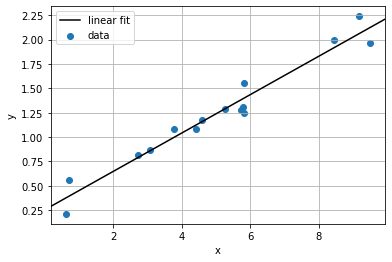

In [12]:
# plot the fit
plotdata()
plotline(w[0], w[1], label="linear fit")

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

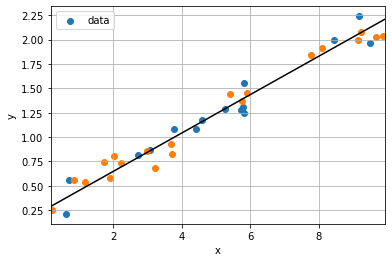

In [13]:
# plot fit on out of sample data
plotdata()
plotline(w[0], w[1])

xtest,ytest = sample_data(20)
plt.scatter(xtest,ytest,label="test")

# Approximating with a polynomial

In [14]:
# first, construct a Vandermonde matrix
max_order = 10
X = np.zeros((n, max_order+1))
for k in range(max_order+1):
    X[:,k] = x**(k)
X

array([[1.00000000e+00, 6.11362741e-01, 3.73764401e-01, 2.28505629e-01,
        1.39699828e-01, 8.54072696e-02, 5.22148225e-02, 3.19221970e-02,
        1.95160419e-02, 1.19313809e-02, 7.29440171e-03],
       [1.00000000e+00, 2.72907808e+00, 7.44786718e+00, 2.03258111e+01,
        5.54707256e+01, 1.51383941e+02, 4.13138597e+02, 1.12748749e+03,
        3.07700140e+03, 8.39737707e+03, 2.29170977e+04],
       [1.00000000e+00, 7.13149195e-01, 5.08581774e-01, 3.62694683e-01,
        2.58655421e-01, 1.84459905e-01, 1.31547433e-01, 9.38129459e-02,
        6.69026268e-02, 4.77115545e-02, 3.40254567e-02],
       [1.00000000e+00, 5.82820938e+00, 3.39680246e+01, 1.97972760e+02,
        1.15382670e+03, 6.72474357e+03, 3.91932136e+04, 2.28426255e+05,
        1.33131604e+06, 7.75918866e+06, 4.52221761e+07],
       [1.00000000e+00, 3.78340496e+00, 1.43141531e+01, 5.41562379e+01,
        2.04894979e+02, 7.75200680e+02, 2.93289810e+03, 1.10963412e+04,
        4.19819524e+04, 1.58834727e+05, 6.00936095e+

In [15]:
# create a pandas dataframe to view the data
col_list = []
for num in range(max_order + 1): 
    col_list.append("order" + str(num))
    
df1 = pd.DataFrame(data = X, columns=col_list)
df1

,order0,order1,order2,order3,order4,order5,order6,order7,order8,order9,order10
0,1.0,0.611363,0.373764,0.228506,0.139700,0.085407,0.052215,3.192220e-02,1.951604e-02,1.193138e-02,7.294402e-03
1,1.0,2.729078,7.447867,20.325811,55.470726,151.383941,413.138597,1.127487e+03,3.077001e+03,8.397377e+03,2.291710e+04
2,1.0,0.713149,0.508582,0.362695,0.258655,0.184460,0.131547,9.381295e-02,6.690263e-02,4.771155e-02,3.402546e-02
3,1.0,5.828209,33.968025,197.972760,1153.826696,6724.743574,39193.213595,2.284263e+05,1.331316e+06,7.759189e+06,4.522218e+07
4,1.0,3.783405,14.314153,54.156238,204.894979,775.200680,2932.898101,1.109634e+04,4.198195e+04,1.588347e+05,6.009361e+05
5,1.0,4.411477,19.461126,85.852305,378.735443,1670.782570,7370.618337,3.251531e+04,1.434405e+05,6.327846e+05,2.791514e+06
6,1.0,5.266508,27.736106,146.072426,769.291601,4051.480364,21337.153723,1.123723e+05,5.918096e+05,3.116770e+06,1.641449e+07
7,1.0,5.745050,33.005603,189.618850,1089.369832,6258.484487,35955.308230,2.065651e+05,1.186727e+06,6.817804e+06,3.916863e+07
8,1.0,9.183126,84.329811,774.411310,7111.516953,65305.959112,599712.877567,5.507239e+06,5.057367e+07,4.644244e+08,4.264868e+09
9,1.0,8.457164,71.523616,604.886927,5115.627712,43263.700567,365888.194420,3.094376e+06,2.616965e+07,2.213210e+08,1.871748e+09


In [16]:
# solve least squares problem
w = np.linalg.lstsq(X, y)[0]
print(w)

[-1.79481446e+00 -6.89372384e-01  1.56186211e+01 -2.17766911e+01
  1.39209976e+01 -5.07549916e+00  1.13807320e+00 -1.59850037e-01
  1.37058235e-02 -6.55557125e-04  1.33969977e-05]


<ipython-input-16-f5119545f4ce>:2: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [17]:
#computes our polynomial fit evaluated at x
def p(x, order = max_order, w = w):
    y = 0
    for k in range(order+1):
        y += w[k]*x**k
    return np.array(y)

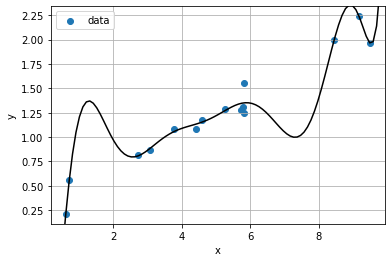

In [18]:
# plot fit
plotdata()
plotfunc(p, xmin=0, xmax=10)

Is this a good model? Would you trust this model to make predictions on new inputs $x$?

* (A) yes 
* (B) no

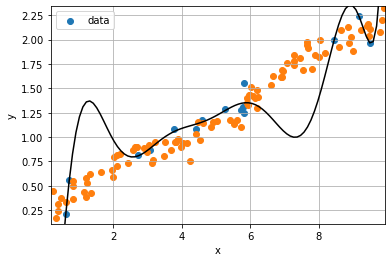

In [19]:
# plot fit on out of sample data
plotdata()
plotfunc(p, xmin=0, xmax=10)

xtest,ytest = sample_data(100)
plt.scatter(xtest,ytest,label="test")

# Choosing the best model order

In [20]:
max_model_order = 10
rmse = np.zeros(max_model_order+1)       # array to store root mean square model errors
rmse_train = np.zeros(max_model_order+1) # array to store root mean square model errors on training set
xtest,ytest = sample_data(50)   # generate test set
Y = y[None, ].T

for model_order in range(max_model_order+1):
    # form Vandermonde matrix
    X = np.zeros((n, model_order+1))
    for k in range(model_order+1):
        X[:,k] = x**k
    
    # solve least squares problem
    w = np.linalg.lstsq(X, y)[0]
    
    # compute training error 
    rmse_train[model_order] = np.mean(np.abs(Y - X@w[None, ].T)) # sqrt(mean((y - X*w).^2))
    
    # compute test error
    ptest = np.array([p(x, order=model_order, w=w) for x in xtest])
    rmse[model_order] = np.mean(np.abs(ytest - ptest)) # sqrt(mean((ytest - ptest).^2))
rmse

<ipython-input-20-b4aa13a756b0>:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


array([0.53065397, 0.09289297, 0.09156674, 0.0930046 , 0.11046556,
       0.10603943, 0.3701449 , 0.38818205, 0.42281022, 0.46344639,
       0.43179525])

Text(0, 0.5, 'rmse')

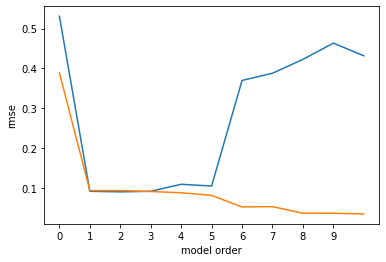

In [27]:
plt.plot(range(max_model_order+1),rmse, label="test error")
plt.plot(range(max_model_order+1),rmse_train, label="train error")
plt.xticks(np.arange(0,10,step=1.0))
plt.xlabel("model order")
plt.ylabel("rmse")

# Polynomial models for classification

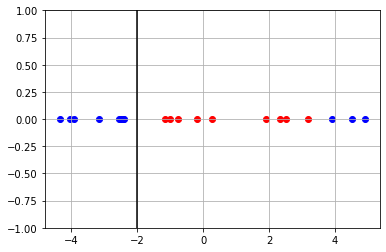

In [52]:
random.seed(0)
n = 20
xs = 10*(np.random.rand(n) - .5)
ys = (xs)**2
pos = (xs - 1)**2 >= 7
zn=np.zeros(n)
pt = plt.scatter(xs[pos],zn[pos],color="blue", label="positive")
plt.scatter(xs[~pos],zn[~pos],color="red", label="negative")
plt.plot([-2,-2], [-1,1], color="black", label="classification boundary")#, ticks=:none, border=:none, legend=false)
plt.ylim([-1,1])
plt.grid()
# savefig("poly-class-1d.pdf")
pt

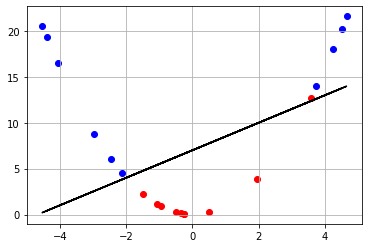

In [51]:
pt = plt.scatter(xs[pos],ys[pos],color="blue", label="positive")
plt.scatter(xs[~pos],ys[~pos],color="red", label="negative")
plt.plot(xs, 1.5*xs + 7, color="black", label="classification boundary")
plt.grid()
# savefig("poly-class-2d.pdf")
pt

In [ ]:
# Example 1: multivariate polynomial classification 
n = 1000
scale = 50
x1 = scale*np.random.rand(n) - scale/2
x2 = scale*np.random.rand(n) - scale/2
f = lambda x1, x2: -30 - 9*x1 + 2*x2 + x1**2 - 0*x1*x2 + x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

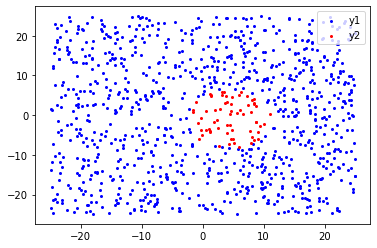

In [66]:
plt.scatter(x1[pos], x2[pos], color="blue", s=4, label='y1')
plt.scatter(x1[neg], x2[neg], color="red", s=4, label='y2')
plt.legend(loc="upper right")

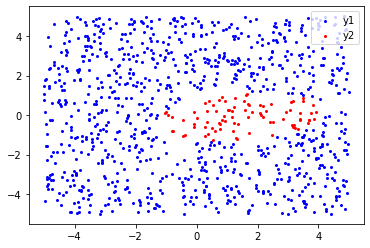

In [69]:
# Example 2: multivariate polynomial classification 
n = 1000
scale = 10
x1 = scale*np.random.rand(n) - scale/2
x2 = scale*np.random.rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 + 5*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], s=4, color="blue", label="y1")
plt.scatter(x1[neg], x2[neg], s=4, color="red", label="y2")
plt.legend(loc="upper right")

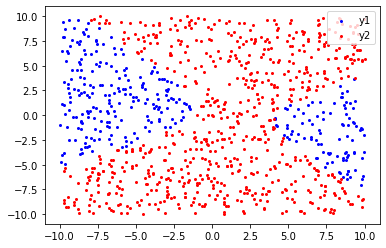

In [70]:
# Example 3: multivariate polynomial classification 
n = 1000
scale = 20
x1 = scale*np.random.rand(n) - scale/2
x2 = scale*np.random.rand(n) - scale/2
f = lambda x1, x2: -5 - 3*x1 + 2*x2 + x1**2 - x1*x2 - 2*x2**2
y = f(x1,x2)
pos = y>0
neg = y<0

plt.scatter(x1[pos], x2[pos], color="blue", s=4, label="y1")
plt.scatter(x1[neg], x2[neg], color="red", s=4, label="y2")
plt.legend(loc="upper right")